In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


# Import the data
df = pd.read_excel('Data\data_to_model_adj.xls', '2.2')

print(df.head(5))
print(df.tail(10))

   year  month  electricity_sold_total
0  1995      1                   25.64
1  1995      2                   25.19
2  1995      3                   30.12
3  1995      4                   21.60
4  1995      5                   20.52
     year  month  electricity_sold_total
296  2019      9               20.772170
297  2019     10               23.792427
298  2019     11               25.496339
299  2019     12               25.714433
300  2020      1               25.527160
301  2020      2               24.064692
302  2020      3               24.026254
303  2020      4               19.066128
304  2020      5               18.831802
305  2020      6               18.775378


In [2]:
# Remove rows from year 2020 to capture pre-covid trend
df.drop(305, axis=0,inplace=True)
df.drop(304, axis=0,inplace=True)
df.drop(303, axis=0,inplace=True)
df.drop(302, axis=0,inplace=True)
df.drop(301, axis=0,inplace=True)
df.drop(300, axis=0,inplace=True)

print(df.tail(5))

     year  month  electricity_sold_total
295  2019      8               20.704741
296  2019      9               20.772170
297  2019     10               23.792427
298  2019     11               25.496339
299  2019     12               25.714433


In [3]:
# Create column that combines year and month
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

# Convert to datetime
df['year_month'] = pd.to_datetime(df['year_month'])

# Set date column as index
df.set_index('year_month',inplace=True)

# Remove no longer required columns
df = df.drop(columns=['year', 'month'])

print(df.head())

            electricity_sold_total
year_month                        
1995-01-01                   25.64
1995-02-01                   25.19
1995-03-01                   30.12
1995-04-01                   21.60
1995-05-01                   20.52


In [4]:
# Print the descriptive statistics
print(df.describe())

       electricity_sold_total
count              300.000000
mean                25.648964
std                  3.225772
min                 19.390000
25%                 23.293594
50%                 25.340549
75%                 27.630084
max                 34.180000


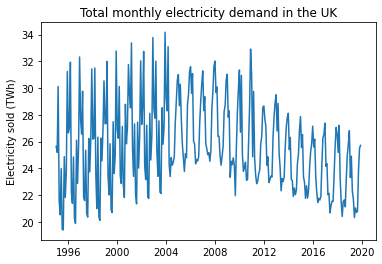

In [5]:
# View the historical data plot

plt.plot(df)
plt.title("Total monthly electricity demand in the UK")
plt.ylabel("Electricity sold (TWh)")
plt.show()

In [6]:
### Testing For Stationarity

test_result = adfuller(df['electricity_sold_total'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(electricity_sold_total):
    result = adfuller(electricity_sold_total)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(df['electricity_sold_total'])


ADF Test Statistic : -0.35212202742955423
p-value : 0.9177910224097396
#Lags Used : 14
Number of Observations Used : 285
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


year_month
1995-01-01    25.64
1995-02-01    25.19
1995-03-01    30.12
1995-04-01    21.60
1995-05-01    20.52
Name: electricity_sold_total, dtype: float64
year_month
1995-01-01          NaN
1995-02-01    25.640000
1995-03-01    25.190000
1995-04-01    30.120000
1995-05-01    21.600000
                ...    
2019-08-01    21.028948
2019-09-01    20.704741
2019-10-01    20.772170
2019-11-01    23.792427
2019-12-01    25.496339
Name: electricity_sold_total, Length: 300, dtype: float64
            electricity_sold_total  electricity_sold_total First Difference  \
year_month                                                                    
1995-01-01                   25.64                                      NaN   
1995-02-01                   25.19                                    -0.45   
1995-03-01                   30.12                                     4.93   
1995-04-01                   21.60                                    -8.52   
1995-05-01                   20.52   

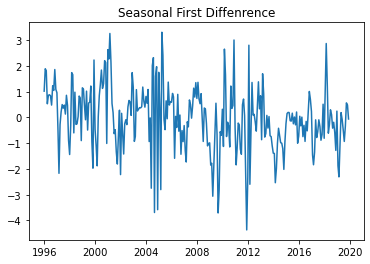

<Figure size 1440x720 with 0 Axes>

In [7]:
### Differencing

print(df['electricity_sold_total'].head())
df['electricity_sold_total First Difference'] = df['electricity_sold_total'] - df['electricity_sold_total'].shift(1)
print(df['electricity_sold_total'].shift(1))
df['Seasonal First Difference'] = df['electricity_sold_total'] - df['electricity_sold_total'].shift(12)

print(df.head(14))

## Again test Dickey Fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

plt.plot(df['Seasonal First Difference'])
plt.title("Seasonal First Diffenrence")
plt.figure(figsize=(12,8))
plt.show()

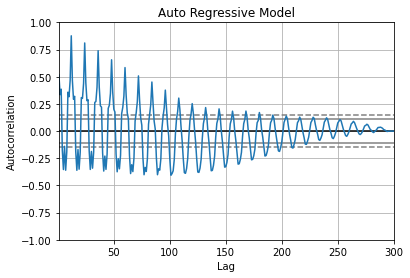

<Figure size 864x576 with 0 Axes>

In [8]:
# Auto Regressive Model

autocorrelation_plot(df['electricity_sold_total'])

plt.title("Auto Regressive Model")
plt.figure(figsize=(12,8))
plt.show()

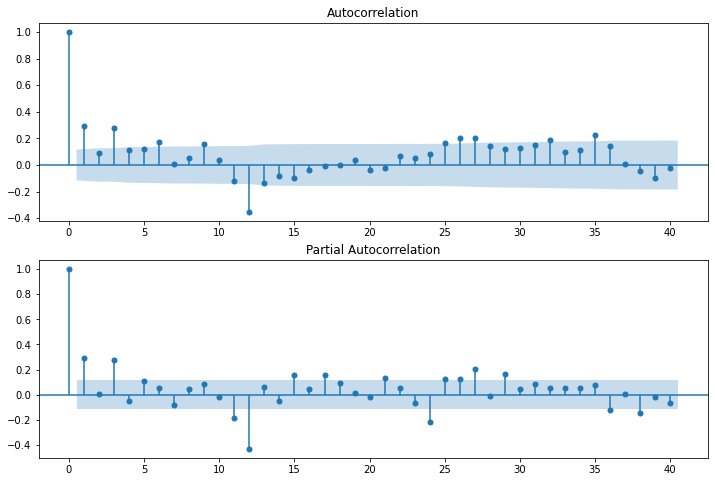

In [9]:
# Autocorrelation and Partial Autocorrelation

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

plt.show()

In [10]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

model = ARIMA(df['electricity_sold_total'], order=(1,1,1))
model_fit = model.fit()


c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmode

In [11]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                 
====================================================================================
Dep. Variable:     D.electricity_sold_total   No. Observations:                  299
Model:                       ARIMA(1, 1, 1)   Log Likelihood                -748.203
Method:                             css-mle   S.D. of innovations              2.954
Date:                      Fri, 18 Sep 2020   AIC                           1504.406
Time:                              00:37:45   BIC                           1519.208
Sample:                          02-01-1995   HQIC                          1510.330
                               - 12-01-2019                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0017      0.105     -0.016      0.987      -0.207       0.204
ar.L1.D.electricity_sold_total    -0.0144      0.185     -0.078      0.938      -0.377       0.348
ma.L1.D.electricity_sold_total    -0.3786      0.177     -2.141      0.032      -0.725      -0.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -69.3180           +0.0000j           69.3180            0.5000
MA.1            2.6416           +0.0000j            2.6416            0.0000
-----------------------------------------------------------------------------
"""

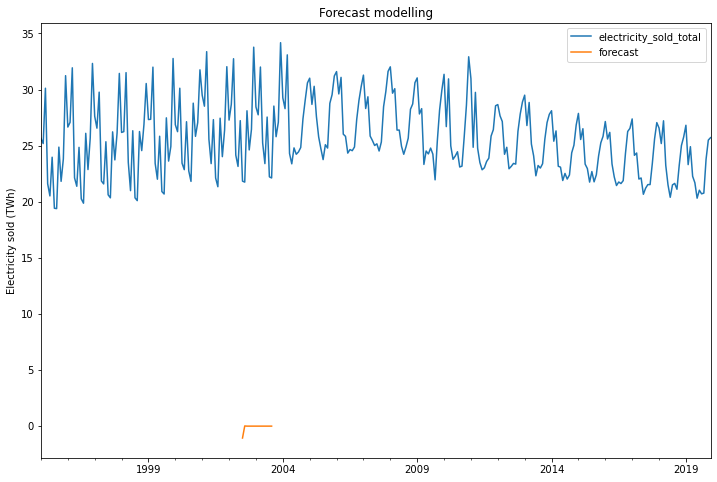

In [12]:
# Forecast modelling 

df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['electricity_sold_total','forecast']].plot(figsize=(12,8))

plt.title("Forecast modelling")
plt.ylabel("Electricity sold (TWh)")
plt.xlabel("")
plt.show()

c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\44790\documents\coding\code first python\project\bigdatachallenge\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


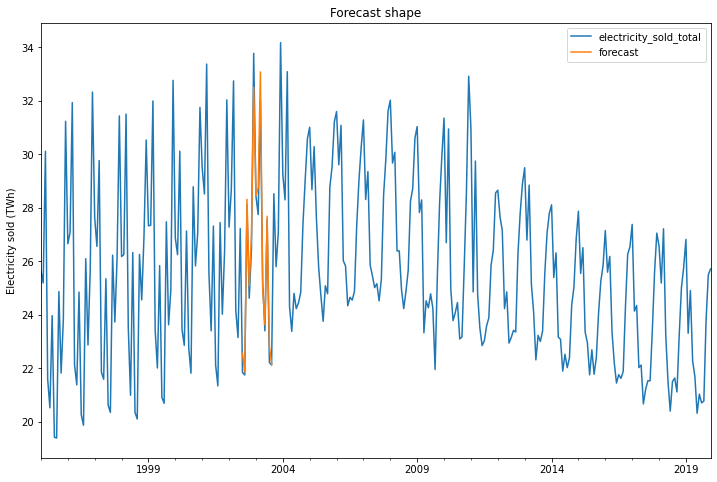

In [13]:
# Modelling the forecast shape

model=sm.tsa.statespace.SARIMAX(df['electricity_sold_total'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['electricity_sold_total','forecast']].plot(figsize=(12,8))

plt.title("Forecast shape")
plt.ylabel("Electricity sold (TWh)")
plt.xlabel("")
plt.show()

In [14]:
# Estimating future movements 

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

print(future_datest_df.tail())

future_df=pd.concat([df,future_datest_df])

           electricity_sold_total electricity_sold_total First Difference  \
2021-07-01                    NaN                                     NaN   
2021-08-01                    NaN                                     NaN   
2021-09-01                    NaN                                     NaN   
2021-10-01                    NaN                                     NaN   
2021-11-01                    NaN                                     NaN   

           Seasonal First Difference forecast  
2021-07-01                       NaN      NaN  
2021-08-01                       NaN      NaN  
2021-09-01                       NaN      NaN  
2021-10-01                       NaN      NaN  
2021-11-01                       NaN      NaN  


Text(0, 0.5, 'Electricity sold (TWh)')

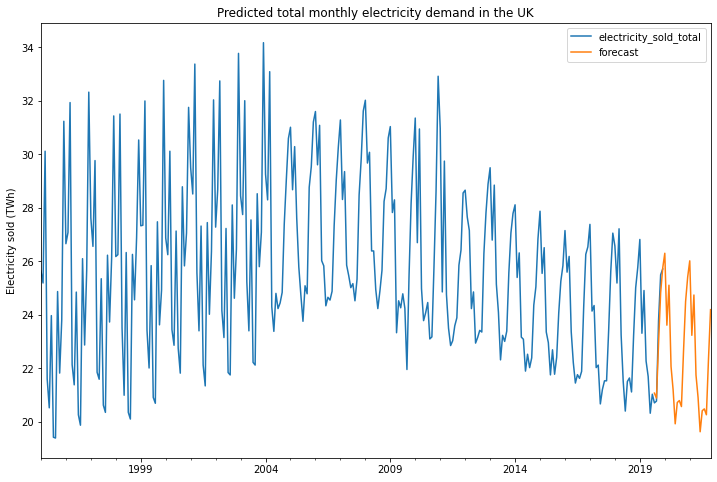

In [15]:
# Set the start and end points of the prediction

future_df['forecast'] = results.predict(start = 295, end = 700, dynamic= True)
future_df[['electricity_sold_total', 'forecast']].plot(figsize=(12, 8))

plt.title("Predicted total monthly electricity demand in the UK")
plt.ylabel("Electricity sold (TWh)")
